In [1]:
import pandas as pd
import os
import hashlib

In [8]:
df[df['email']=='dipak.tandel96@gmail.com']

,email,company,normalized_company_name,orgyear,ctc,job_position,ctc_updated_year
24129,dipak.tandel96@gmail.com,Sify Technologies Limited.,Sify Technologies,2018.0,720000,NaN,2020.0
46038,dipak.tandel96@gmail.com,Sify Technologies Limited.,Sify Technologies,2018.0,720000,Support Engineer,2020.0
72415,dipak.tandel96@gmail.com,Sify Technologies Limited.,Sify Technologies,2018.0,720000,Other,2020.0
103145,dipak.tandel96@gmail.com,Sify Technologies Limited.,Sify Technologies,2018.0,720000,FullStack Engineer,2020.0
118076,dipak.tandel96@gmail.com,Sify Technologies Limited.,Sify Technologies,2018.0,720000,Data Analyst,2020.0
121825,dipak.tandel96@gmail.com,Sify Technologies Limited.,Sify Technologies,2018.0,660000,Other,2019.0
124840,dipak.tandel96@gmail.com,Sify Technologies Limited.,Sify Technologies,2018.0,660000,Support Engineer,2019.0
145021,dipak.tandel96@gmail.com,Sify Technologies Limited.,Sify Technologies,2018.0,660000,FullStack Engineer,2019.0
153402,dipak.tandel96@gmail.com,Sify Technologies Limited.,Sify Technologies,2018.0,660000,Devops Engineer,2019.0
160472,dipak.tandel96@gmail.com,Sify Technologies Limited.,Sify Technologies,2018.0,660000,NaN,2019.0


In [9]:
pd.DataFrame(df.job_position.value_counts(normalize=True)*100)[0:15] # 94% is captured here 

,job_position
Backend Engineer,28.413611
FullStack Engineer,16.130610
Other,11.786725
Frontend Engineer,6.799181
Engineering Leadership,4.480834
QA Engineer,4.296279
Data Scientist,3.501324
Android Engineer,3.496107
SDET,3.239165
Devops Engineer,3.008308


# Hashing of email, Null Imputation & Dropping of unnecessary columns

In [10]:
# annonymise email
# Apply hashing function to the column
df['email_hash'] = df['email'].apply(
    lambda x: 
        hashlib.sha256(x.encode()).hexdigest()
)
temp_cols=df.columns.tolist()
new_cols=temp_cols[-1:] + temp_cols[:-1]
df=df[new_cols]

df.drop(columns='email',inplace=True)



In [11]:
#student analysis begings from here

#do that step of getting rows agains 1 email -- value_counts()

In [12]:
df.drop(columns=['normalized_company_name'],inplace=True)
df.drop(columns=['email_hash'],inplace=True)
#dropping email will create different records and there will be no confusion for clustering

In [13]:
df.isnull().sum()/len(df)*100

company              0.825428
orgyear              0.041561
ctc                  0.000000
job_position        25.894173
ctc_updated_year     0.000000
dtype: float64

In [14]:
df.drop_duplicates(inplace=True)
df.shape

(188616, 5)

# Data Preprocessing
### Removing special characters from company & Job Position

In [15]:
import re
def remove_special (string):
    new_string=re.sub('[^A-Za-z0-9 ]+', '', string)
    return new_string
    

In [16]:
#what happens here
mystring='\tAirtel X Labs'
re.sub('[^A-Za-z0-9 ]+', '', mystring)

'Airtel X Labs'

In [17]:
df.company=df.company.apply(lambda x: remove_special(str(x)))
df.company=df.company.apply(lambda x: x.lower())
df.company=df.company.apply(lambda x: x.strip())
df.company

0                    deloitte india
1         reliance infocomm limited
2                     synctactic ai
3                         tokopedia
4                        rift group
                    ...            
206918                    apple inc
206919                    upgradcom
206920                     accolite
206921               not applicable
206922               morgan stanley
Name: company, Length: 188616, dtype: object

In [18]:
df.job_position=df.job_position.apply(lambda x: remove_special(str(x)))
df.job_position=df.job_position.apply(lambda x: x.lower())
df.job_position=df.job_position.apply(lambda x: x.strip())
df.job_position

0                      other
1         fullstack engineer
2           backend engineer
3           backend engineer
4         fullstack engineer
                 ...        
206918                   nan
206919                   nan
206920                   nan
206921                   nan
206922                   nan
Name: job_position, Length: 188616, dtype: object

In [19]:
df.drop_duplicates(inplace=True)
df.shape

(188261, 5)

### Filling Null values using Mean Target Inputation for Orgyear

In [20]:
company_median_org_year=df.groupby('company')['orgyear'].median()

In [21]:
import numpy as np
def null_imputation(table, main_col, null_col):
    if np.isnan(null_col):
        return table[main_col]
    else:
        return null_col
#can do knn imputation as well
df['orgyear']=df.apply(lambda x: null_imputation(company_median_org_year,x['company'],x['orgyear'] ), axis=1)    

In [22]:
len(df[df['orgyear'].isnull()])

26

In [23]:
df=df[~df['orgyear'].isnull()]

In [24]:
#checking for outliers in orgyear
df.orgyear.value_counts().sort_values(ascending=True)

200.0         1
208.0         1
38.0          1
2204.0        1
1900.0        1
          ...  
2019.0    18578
2015.0    19621
2017.0    21324
2016.0    21484
2018.0    22175
Name: orgyear, Length: 79, dtype: int64

In [25]:
#removing outliers from orgyear using IQR

q1=df.orgyear.quantile(0.25)
q3=df.orgyear.quantile(0.75)
iqr=q3-q1

df=df.loc[(df.orgyear>=q1-1.5*iqr) & (df.orgyear<=q3+1.5*iqr)]


#removing outliers from ctc using IQR

q1=df.ctc.quantile(0.25)
q3=df.ctc.quantile(0.75)
iqr=q3-q1

df=df.loc[(df.ctc>=q1-1.5*iqr) & (df.ctc<=q3+1.5*iqr)]

In [26]:
df.shape

(169083, 5)

## Masking companies having count less than 5

In [27]:
df=df.apply(lambda x: x.mask(x.map(x.value_counts())<=5,'Others') if x.name=='company' else x)

In [28]:
df .company.value_counts()

Others                       46864
tata consultancy services     4111
infosys                       2910
amazon                        2227
cognizant                     2116
                             ...  
infinx                           6
paycraft                         6
ashok leyland                    6
bed bath  beyond                 6
sumtotal systems                 6
Name: company, Length: 2941, dtype: int64

#### Creating Years of Experience Columns

In [29]:
df.drop_duplicates(inplace=True)
df.shape

(147166, 5)

In [30]:
#orgyear check
df['orgyear'] = df.apply(lambda x: x['orgyear'] if x['orgyear'] <=
                     2022 else 2022, axis=1)

In [31]:
df['years_of_experience']=2022-df['orgyear']

In [32]:
df.drop_duplicates(inplace=True)
df.shape

(147127, 6)

In [33]:
df=df[~df['years_of_experience'].isnull()]

In [34]:
#ctc_updated_year_check
df['ctc_updated_year'] = df.apply(lambda x: x['orgyear'] if x['ctc_updated_year'] <
                     x['orgyear'] else x['ctc_updated_year'], axis=1)

In [35]:
#Filling null values with others
df['job_position'] = df['job_position'].fillna('Others')
df['company'] = df['company'].fillna('Others')

In [36]:
df.loc[df['job_position']=='nan','job_position']=np.nan

In [37]:
df.isnull().sum()

company                    0
orgyear                    0
ctc                        0
job_position           33365
ctc_updated_year           0
years_of_experience        0
dtype: int64

In [38]:
df.drop_duplicates(inplace=True)
df.shape

(146077, 6)

In [39]:
df.describe()

,orgyear,ctc,ctc_updated_year,years_of_experience
count,146077.000000,1.460770e+05,146077.000000,146077.000000
mean,2015.449869,1.129338e+06,2019.598349,6.550131
std,3.300423,7.440049e+05,1.339290,3.300423
min,2006.000000,2.000000e+00,2015.000000,0.000000
25%,2013.000000,5.700000e+05,2019.000000,4.000000
50%,2016.000000,9.600000e+05,2020.000000,6.000000
75%,2018.000000,1.560000e+06,2021.000000,9.000000
max,2022.000000,3.330000e+06,2022.000000,16.000000


In [40]:
#pd.DataFrame(df['job_position'].value_counts()).to_csv('scaler_job_positions.csv')

# Spell Check

In [41]:
# find those words that may be misspelled
#from spellchecker import SpellChecker

#spell = SpellChecker()

#misspelled = spell.unknown(list(df['company'].values)[:10])
#dicter={}
#for word in misspelled:
    # Get the one `most likely` answer
#    dicter[word]=spell.correction(word)
    
#print(dicter)



In [42]:
#merge the mapping with the original one
job_map=pd.read_csv('scaler_job_positions_mapping VX.csv')

In [43]:
job_map[:100]

,Original,New
0,7,others
1,91,others
2,737,others
3,857628,others
4,896651,others
...,...,...
95,atm interface system,atm interface system
96,audit manager,audit manager
97,auditing,auditor
98,auditor,auditor


In [44]:
job_map.shape

(801, 2)

In [45]:
job_map.drop_duplicates(inplace=True)

In [46]:
df=df.merge(job_map, left_on='job_position', right_on='Original', how='left')

In [47]:
df.shape

(146077, 8)

In [48]:
df.isnull().sum()

company                    0
orgyear                    0
ctc                        0
job_position           32768
ctc_updated_year           0
years_of_experience        0
Original               32821
New                       53
dtype: int64

In [49]:
df.drop(columns=['job_position','Original'],inplace=True)
df['job_position']=df['New']
df.drop(columns=['New'],inplace=True)


In [50]:
df.drop_duplicates(inplace=True)
df.shape

(140894, 6)

In [51]:
df=df[~(df['job_position'].isnull())]

In [52]:
df.shape

(140841, 6)

## Manual Clustering based on company, job position and years of experience

In [53]:
grouped_c_j_y=df.groupby(['years_of_experience','job_position','company'])['ctc'].describe()

In [54]:
grouped_c_j_y

count  \
years_of_experience job_position       company                                   
0.0                 analyst programmer Others                              1.0   
                    android engineer   Others                              5.0   
                                       accenture                           1.0   
                                       hike messenger                      1.0   
                                       im  a student                       2.0   
...                                                                        ...   
16.0                support engineer   ocwen financial corporation  us     1.0   
                                       oracle                              1.0   
                                       samsung research institute noida    1.0   
                                       tata consultancy services           1.0   
                    team lead          persistent systems                  1.0   

                                                                              mean  \
years_of_experience job_position       company                                       
0.0                 analyst programmer Others                             360000.0   
                    android engineer   Others                             706000.0   
                                       accenture                          450000.0   
                                       hike messenger                     300000.0   
                                       im  a student                     1350000.0   
...                                                                            ...   
16.0                support engineer   ocwen financial corporation  us   1500000.0   
                                       oracle                            2600000.0   
                                       samsung research institute noida  1400000.0   
                                       tata consultancy services         1500000.0   
                    team lead          persistent systems                1600000.0   

                                                                                  std  \
years_of_experience job_position       company                                          
0.0                 analyst programmer Others                                     NaN   
                    android engineer   Others                            4.417918e+05   
                                       accenture                                  NaN   
                                       hike messenger                             NaN   
                                       im  a student                     1.626346e+06   
...                                                                               ...   
16.0                support engineer   ocwen financial corporation  us            NaN   
                                       oracle                                     NaN   
                                       samsung research institute noida           NaN   
                                       tata consultancy services                  NaN   
                    team lead          persistent systems                         NaN   

                                                                               min  \
years_of_experience job_position       company                                       
0.0                 analyst programmer Others                             360000.0   
                    android engineer   Others                             100000.0   
                                       accenture                          450000.0   
                                       hike messenger                     300000.0   
                                       im  a student                      200000.0   
...                                                                            ...   
16.0                support engineer   oc

In [55]:
df_cjy=df.merge(grouped_c_j_y, on=['years_of_experience','job_position','company'], how='left')

In [56]:
df_cjy.sort_values(['years_of_experience','job_position','company'])

,company,orgyear,ctc,ctc_updated_year,years_of_experience,job_position,count,mean,std,min,25%,50%,75%,max
25585,Others,2022.0,360000,2022.0,0.0,analyst programmer,1.0,360000.0,NaN,360000.0,360000.0,360000.0,360000.0,360000.0
4395,Others,2022.0,480000,2022.0,0.0,android engineer,5.0,706000.0,441791.806171,100000.0,480000.0,700000.0,1050000.0,1200000.0
17016,Others,2022.0,1200000,2022.0,0.0,android engineer,5.0,706000.0,441791.806171,100000.0,480000.0,700000.0,1050000.0,1200000.0
30837,Others,2022.0,100000,2022.0,0.0,android engineer,5.0,706000.0,441791.806171,100000.0,480000.0,700000.0,1050000.0,1200000.0
104059,Others,2022.0,1050000,2022.0,0.0,android engineer,5.0,706000.0,441791.806171,100000.0,480000.0,700000.0,1050000.0,1200000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132005,ocwen financial corporation us,2006.0,1500000,2021.0,16.0,support engineer,1.0,1500000.0,NaN,1500000.0,1500000.0,1500000.0,1500000.0,1500000.0
52888,oracle,2006.0,2600000,2021.0,16.0,support engineer,1.0,2600000.0,NaN,2600000.0,2600000.0,2600000.0,2600000.0,2600000.0
124794,samsung research institute noida,2006.0,1400000,2020.0,16.0,support engineer,1.0,1400000.0,NaN,1400000.0,1400000.0,1400000.0,1400000.0,1400000.0
35554,tata consultancy services,2006.0,1500000,2021.0,16.0,support engineer,1.0,1500000.0,NaN,1500000.0,1500000.0,1500000.0,1500000.0,1500000.0


In [57]:
df_cjy.drop_duplicates(inplace=True)
df_cjy.shape
#no change till now

(140841, 14)

### Creating Designation basis on the salary they are getting in their respective company

In [58]:
def condition_designation(a,b_50,b_75):
    if a<b_50:
        return 3
    elif a>=b_50 and a<=b_75:
        return 2
    
    elif a>=b_75:
        return 1
        

In [59]:
df.head()

,company,orgyear,ctc,ctc_updated_year,years_of_experience,job_position
0,deloitte india,2016.0,1100000,2020.0,6.0,others
1,reliance infocomm limited,2018.0,449999,2019.0,4.0,fullstack devloper
2,Others,2015.0,2000000,2020.0,7.0,backend engineer
3,tokopedia,2017.0,700000,2019.0,5.0,backend engineer
4,rift group,2017.0,1400000,2019.0,5.0,fullstack devloper


In [60]:
df_cjy['designation'] =df_cjy.apply(lambda x: condition_designation(x['ctc'],x['50%'],x['75%']),axis=1)

In [61]:
df_cjy.head()

,company,orgyear,ctc,ctc_updated_year,years_of_experience,job_position,count,mean,std,min,25%,50%,75%,max,designation
0,deloitte india,2016.0,1100000,2020.0,6.0,others,1.0,1.100000e+06,NaN,1100000.0,1100000.0,1100000.0,1100000.0,1100000.0,2
1,reliance infocomm limited,2018.0,449999,2019.0,4.0,fullstack devloper,7.0,7.742856e+05,250922.324350,449999.0,610000.0,750000.0,900000.0,1200000.0,3
2,Others,2015.0,2000000,2020.0,7.0,backend engineer,456.0,9.609559e+05,776546.830662,1000.0,307500.0,800000.0,1435000.0,3200000.0,1
3,tokopedia,2017.0,700000,2019.0,5.0,backend engineer,7.0,1.158571e+06,404780.951933,700000.0,825000.0,1200000.0,1405000.0,1750000.0,3
4,rift group,2017.0,1400000,2019.0,5.0,fullstack devloper,1.0,1.400000e+06,NaN,1400000.0,1400000.0,1400000.0,1400000.0,1400000.0,2


In [62]:
df_cjy.designation.value_counts(normalize=True)*100

2    43.322612
3    34.705093
1    21.972295
Name: designation, dtype: float64

## Manual Clustering based on company and job position 

In [63]:
grouped_c_j=df.groupby(['job_position','company'])['ctc'].describe()

In [64]:
grouped_c_j

,,count,mean,std,min,25%,50%,75%,max
job_position,company,,,,,,,,
abap developer,Others,1.0,500000.0,NaN,500000.0,500000.0,500000.0,500000.0,500000.0
account,not applicable account,1.0,2000000.0,NaN,2000000.0,2000000.0,2000000.0,2000000.0,2000000.0
administrative clerk,Others,1.0,500000.0,NaN,500000.0,500000.0,500000.0,500000.0,500000.0
administrator,Others,1.0,380000.0,NaN,380000.0,380000.0,380000.0,380000.0,380000.0
advisor,fis,1.0,360000.0,NaN,360000.0,360000.0,360000.0,360000.0,360000.0
...,...,...,...,...,...,...,...,...,...
web designer intern,the sparks foundation,1.0,420000.0,NaN,420000.0,420000.0,420000.0,420000.0,420000.0
web developer full stack,another company,1.0,300000.0,NaN,300000.0,300000.0,300000.0,300000.0,300000.0
webcenter consultant,larsen toubro infotech ltd,1.0,300000.0,NaN,300000.0,300000.0,300000.0,300000.0,300000.0


In [65]:
df

,company,orgyear,ctc,ctc_updated_year,years_of_experience,job_position
0,deloitte india,2016.0,1100000,2020.0,6.0,others
1,reliance infocomm limited,2018.0,449999,2019.0,4.0,fullstack devloper
2,Others,2015.0,2000000,2020.0,7.0,backend engineer
3,tokopedia,2017.0,700000,2019.0,5.0,backend engineer
4,rift group,2017.0,1400000,2019.0,5.0,fullstack devloper
...,...,...,...,...,...,...
146072,barclays,2011.0,2250000,2019.0,11.0,others
146073,apple inc,2008.0,220000,2019.0,14.0,others
146074,upgradcom,2017.0,500000,2020.0,5.0,others
146075,accolite,2021.0,700000,2021.0,1.0,others


In [66]:
df.drop_duplicates().shape

(140841, 6)

In [67]:
df_cj=df.merge(grouped_c_j, on=['job_position','company'], how='left')

In [68]:
df_cj

,company,orgyear,ctc,ctc_updated_year,years_of_experience,job_position,count,mean,std,min,25%,50%,75%,max
0,deloitte india,2016.0,1100000,2020.0,6.0,others,2.0,1.085000e+06,2.121320e+04,1070000.0,1077500.0,1085000.0,1092500.0,1100000.0
1,reliance infocomm limited,2018.0,449999,2019.0,4.0,fullstack devloper,25.0,9.882000e+05,4.874998e+05,300000.0,600000.0,850000.0,1380000.0,2000000.0
2,Others,2015.0,2000000,2020.0,7.0,backend engineer,3876.0,1.001486e+06,8.125128e+05,1000.0,300000.0,830000.0,1530000.0,3300000.0
3,tokopedia,2017.0,700000,2019.0,5.0,backend engineer,24.0,1.416667e+06,5.453413e+05,520000.0,1047500.0,1375000.0,1792500.0,2600000.0
4,rift group,2017.0,1400000,2019.0,5.0,fullstack devloper,3.0,8.466667e+05,4.801389e+05,540000.0,570000.0,600000.0,1000000.0,1400000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140836,barclays,2011.0,2250000,2019.0,11.0,others,64.0,1.259969e+06,5.777488e+05,500000.0,800000.0,1020000.0,1607500.0,3200000.0
140837,apple inc,2008.0,220000,2019.0,14.0,others,16.0,1.568312e+06,1.231984e+06,60000.0,216250.0,2275000.0,2550000.0,3000000.0
140838,upgradcom,2017.0,500000,2020.0,5.0,others,61.0,1.149180e+06,4.866254e+05,400000.0,800000.0,1000000.0,1450000.0,2400000.0
140839,accolite,2021.0,700000,2021.0,1.0,others,38.0,1.221395e+06,5.482048e+05,300000.0,812500.0,1175000.0,1460000.0,2700000.0


In [69]:
df_cj.sort_values(['company','job_position','years_of_experience'])
# [df_cj.sort_values(['company','job_position','years_of_experience'])['company']=='Amazon'][:2]
# df_cj.sort_values(['company','job_position','years_of_experience'])[df_cj.sort_values(['company','job_position','years_of_experience'])['company']=='Amazon'][:2]

,company,orgyear,ctc,ctc_updated_year,years_of_experience,job_position,count,mean,std,min,25%,50%,75%,max
90779,,2015.0,800000,2019.0,7.0,backend engineer,1.0,800000.0,NaN,800000.0,800000.0,800000.0,800000.0,800000.0
99537,,2018.0,2000000,2018.0,4.0,data analyst,1.0,2000000.0,NaN,2000000.0,2000000.0,2000000.0,2000000.0,2000000.0
133783,,2019.0,2000000,2019.0,3.0,data scientist,2.0,1455000.0,770746.391493,910000.0,1182500.0,1455000.0,1727500.0,2000000.0
35682,,2011.0,910000,2019.0,11.0,data scientist,2.0,1455000.0,770746.391493,910000.0,1182500.0,1455000.0,1727500.0,2000000.0
67236,,2019.0,500000,2019.0,3.0,database administrator,1.0,500000.0,NaN,500000.0,500000.0,500000.0,500000.0,500000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63155,zynga,2015.0,1700000,2019.0,7.0,ios engineer,1.0,1700000.0,NaN,1700000.0,1700000.0,1700000.0,1700000.0,1700000.0
30057,zynga,2018.0,2400000,2020.0,4.0,others,4.0,1725000.0,531507.290637,1300000.0,1300000.0,1600000.0,2025000.0,2400000.0
103299,zynga,2016.0,1900000,2019.0,6.0,others,4.0,1725000.0,531507.290637,1300000.0,1300000.0,1600000.0,2025000.0,2400000.0
51193,zynga,2015.0,1300000,2015.0,7.0,others,4.0,1725000.0,531507.290637,1300000.0,1300000.0,1600000.0,2025000.0,2400000.0


In [70]:
df_cj.shape

(140841, 14)

In [71]:
df_cj.drop_duplicates(inplace=True)

In [72]:
df_cj.shape

(140841, 14)

### Creating Class basis on the salary they are getting in their respective company

In [73]:
def condition_classs(a,b_50,b_75):
    if a<b_50:
        return 3
    elif a>=b_50 and a<=b_75:
        return 2
    
    elif a>=b_75:
        return 1
        

In [74]:
df_cj['classs'] =df_cj.apply(lambda x: condition_classs(x['ctc'],x['50%'],x['75%']),axis=1)

In [75]:
df_cj

,company,orgyear,ctc,ctc_updated_year,years_of_experience,job_position,count,mean,std,min,25%,50%,75%,max,classs
0,deloitte india,2016.0,1100000,2020.0,6.0,others,2.0,1.085000e+06,2.121320e+04,1070000.0,1077500.0,1085000.0,1092500.0,1100000.0,1
1,reliance infocomm limited,2018.0,449999,2019.0,4.0,fullstack devloper,25.0,9.882000e+05,4.874998e+05,300000.0,600000.0,850000.0,1380000.0,2000000.0,3
2,Others,2015.0,2000000,2020.0,7.0,backend engineer,3876.0,1.001486e+06,8.125128e+05,1000.0,300000.0,830000.0,1530000.0,3300000.0,1
3,tokopedia,2017.0,700000,2019.0,5.0,backend engineer,24.0,1.416667e+06,5.453413e+05,520000.0,1047500.0,1375000.0,1792500.0,2600000.0,3
4,rift group,2017.0,1400000,2019.0,5.0,fullstack devloper,3.0,8.466667e+05,4.801389e+05,540000.0,570000.0,600000.0,1000000.0,1400000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140836,barclays,2011.0,2250000,2019.0,11.0,others,64.0,1.259969e+06,5.777488e+05,500000.0,800000.0,1020000.0,1607500.0,3200000.0,1
140837,apple inc,2008.0,220000,2019.0,14.0,others,16.0,1.568312e+06,1.231984e+06,60000.0,216250.0,2275000.0,2550000.0,3000000.0,3
140838,upgradcom,2017.0,500000,2020.0,5.0,others,61.0,1.149180e+06,4.866254e+05,400000.0,800000.0,1000000.0,1450000.0,2400000.0,3
140839,accolite,2021.0,700000,2021.0,1.0,others,38.0,1.221395e+06,5.482048e+05,300000.0,812500.0,1175000.0,1460000.0,2700000.0,3


In [76]:
df_cj.classs.value_counts(normalize=True)*100

3    44.073814
2    31.475210
1    24.450977
Name: classs, dtype: float64

In [77]:
#insight

In [78]:
# job position that has the highest class
df_cj[df_cj['classs']==1][['job_position','ctc']].groupby('job_position')['ctc'].describe().sort_values(by=['count','mean'],ascending=False)[:10]

,count,mean,std,min,25%,50%,75%,max
job_position,,,,,,,,
others,10218.0,1.914802e+06,694753.152926,100000.0,1400000.0,1900000.0,2500000.0,3330000.0
backend engineer,8141.0,2.062763e+06,687519.050387,30000.0,1550000.0,2000000.0,2600000.0,3330000.0
fullstack devloper,4737.0,1.844218e+06,688705.831941,59000.0,1350000.0,1750000.0,2360000.0,3330000.0
frontend developer,2001.0,1.668149e+06,631746.759730,90000.0,1210000.0,1550000.0,2030000.0,3300000.0
qa engineer,1264.0,1.393021e+06,629618.259158,65000.0,900000.0,1250000.0,1707500.0,3300000.0
data scientist,1014.0,2.004372e+06,657171.138374,115000.0,1600000.0,2000000.0,2500000.0,3310000.0
software developer 1,999.0,1.559613e+06,720478.817144,140000.0,900000.0,1450000.0,2000000.0,3329999.0
devops engineer,927.0,1.750345e+06,626199.257910,400000.0,1300000.0,1670000.0,2137500.0,3300000.0
android engineer,914.0,1.784936e+06,638355.947537,14000.0,1320000.0,1700000.0,2200000.0,3300000.0


In [79]:
#########
df_cjy.head()

,company,orgyear,ctc,ctc_updated_year,years_of_experience,job_position,count,mean,std,min,25%,50%,75%,max,designation
0,deloitte india,2016.0,1100000,2020.0,6.0,others,1.0,1.100000e+06,NaN,1100000.0,1100000.0,1100000.0,1100000.0,1100000.0,2
1,reliance infocomm limited,2018.0,449999,2019.0,4.0,fullstack devloper,7.0,7.742856e+05,250922.324350,449999.0,610000.0,750000.0,900000.0,1200000.0,3
2,Others,2015.0,2000000,2020.0,7.0,backend engineer,456.0,9.609559e+05,776546.830662,1000.0,307500.0,800000.0,1435000.0,3200000.0,1
3,tokopedia,2017.0,700000,2019.0,5.0,backend engineer,7.0,1.158571e+06,404780.951933,700000.0,825000.0,1200000.0,1405000.0,1750000.0,3
4,rift group,2017.0,1400000,2019.0,5.0,fullstack devloper,1.0,1.400000e+06,NaN,1400000.0,1400000.0,1400000.0,1400000.0,1400000.0,2


In [80]:
df_cj.head()

,company,orgyear,ctc,ctc_updated_year,years_of_experience,job_position,count,mean,std,min,25%,50%,75%,max,classs
0,deloitte india,2016.0,1100000,2020.0,6.0,others,2.0,1.085000e+06,21213.203436,1070000.0,1077500.0,1085000.0,1092500.0,1100000.0,1
1,reliance infocomm limited,2018.0,449999,2019.0,4.0,fullstack devloper,25.0,9.882000e+05,487499.789590,300000.0,600000.0,850000.0,1380000.0,2000000.0,3
2,Others,2015.0,2000000,2020.0,7.0,backend engineer,3876.0,1.001486e+06,812512.814387,1000.0,300000.0,830000.0,1530000.0,3300000.0,1
3,tokopedia,2017.0,700000,2019.0,5.0,backend engineer,24.0,1.416667e+06,545341.270627,520000.0,1047500.0,1375000.0,1792500.0,2600000.0,3
4,rift group,2017.0,1400000,2019.0,5.0,fullstack devloper,3.0,8.466667e+05,480138.868801,540000.0,570000.0,600000.0,1000000.0,1400000.0,1


In [81]:
df_cj.shape

(140841, 15)

In [82]:
df_cjy.shape

(140841, 15)

In [83]:
df_cj.drop(columns=['count','mean','std','min','25%','50%','75%','max'],inplace=True)
df_cjy.drop(columns=['count','mean','std','min','25%','50%','75%','max'],inplace=True)

In [84]:
df_cj.drop_duplicates().shape

(140841, 7)

In [85]:
df_cjy.drop_duplicates().shape

(140841, 7)

In [86]:
df_cjy_cj=df_cj.merge(df_cjy, on=['company','orgyear','ctc','job_position','years_of_experience','ctc_updated_year'], how='left')

In [87]:
df_cjy_cj.shape

(140841, 8)

In [88]:
df_cjy_cj.drop_duplicates().shape

(140841, 8)

In [89]:
#verify if the join is right or now


## Manual Clustering based on comapny

In [90]:
grouped_c=df.groupby(['company'])['ctc'].describe()

In [91]:
df_c=df.merge(grouped_c, on=['company'], how='left')

In [92]:
df_c.head(5)

,company,orgyear,ctc,ctc_updated_year,years_of_experience,job_position,count,mean,std,min,25%,50%,75%,max
0,deloitte india,2016.0,1100000,2020.0,6.0,others,9.0,1.115667e+06,458111.885897,500000.0,800000.0,1070000.0,1500000.0,1771000.0
1,reliance infocomm limited,2018.0,449999,2019.0,4.0,fullstack devloper,377.0,1.065469e+06,636791.154939,10000.0,600000.0,900000.0,1500000.0,3200000.0
2,Others,2015.0,2000000,2020.0,7.0,backend engineer,23257.0,9.759842e+05,766658.805719,15.0,399000.0,800000.0,1400000.0,3329999.0
3,tokopedia,2017.0,700000,2019.0,5.0,backend engineer,58.0,1.465086e+06,656969.712365,200000.0,1100000.0,1325000.0,1875000.0,3160000.0
4,rift group,2017.0,1400000,2019.0,5.0,fullstack devloper,6.0,9.400000e+05,389871.773792,540000.0,625000.0,850000.0,1300000.0,1400000.0


In [93]:
#verify
df_c.sort_values(['company'])

,company,orgyear,ctc,ctc_updated_year,years_of_experience,job_position,count,mean,std,min,25%,50%,75%,max
59454,,2014.0,600000,2019.0,8.0,others,41.0,9.753170e+05,729828.445059,110000.0,400000.0,700000.0,1200000.0,2700000.0
82947,,2015.0,600000,2021.0,7.0,others,41.0,9.753170e+05,729828.445059,110000.0,400000.0,700000.0,1200000.0,2700000.0
120964,,2018.0,956000,2018.0,4.0,others,41.0,9.753170e+05,729828.445059,110000.0,400000.0,700000.0,1200000.0,2700000.0
67236,,2019.0,500000,2019.0,3.0,database administrator,41.0,9.753170e+05,729828.445059,110000.0,400000.0,700000.0,1200000.0,2700000.0
99537,,2018.0,2000000,2018.0,4.0,data analyst,41.0,9.753170e+05,729828.445059,110000.0,400000.0,700000.0,1200000.0,2700000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103299,zynga,2016.0,1900000,2019.0,6.0,others,48.0,1.885000e+06,645738.925738,800000.0,1375000.0,1900000.0,2400000.0,3300000.0
115764,zynga,2016.0,1900000,2019.0,6.0,fullstack devloper,48.0,1.885000e+06,645738.925738,800000.0,1375000.0,1900000.0,2400000.0,3300000.0
91987,zynga,2016.0,1700000,2019.0,6.0,backend engineer,48.0,1.885000e+06,645738.925738,800000.0,1375000.0,1900000.0,2400000.0,3300000.0
71821,zynga,2018.0,1000000,2021.0,4.0,backend engineer,48.0,1.885000e+06,645738.925738,800000.0,1375000.0,1900000.0,2400000.0,3300000.0


In [94]:
print(df.drop_duplicates().shape)
print(df_c.shape)
print(df_c.drop_duplicates().shape)


(140841, 6)
(140841, 14)
(140841, 14)


### Creating Tier basis on the salary in the companies

In [95]:
def condition_tier(a,b_50,b_75):
    if a<b_50:
        return 3
    elif a>=b_50 and a<=b_75:
        return 2
    
    elif a>=b_75:
        return 1

In [96]:
df_c['tier'] =df_c.apply(lambda x: condition_tier(x['ctc'],x['50%'],x['75%']),axis=1)

In [97]:
df_c.head()

,company,orgyear,ctc,ctc_updated_year,years_of_experience,job_position,count,mean,std,min,25%,50%,75%,max,tier
0,deloitte india,2016.0,1100000,2020.0,6.0,others,9.0,1.115667e+06,458111.885897,500000.0,800000.0,1070000.0,1500000.0,1771000.0,2
1,reliance infocomm limited,2018.0,449999,2019.0,4.0,fullstack devloper,377.0,1.065469e+06,636791.154939,10000.0,600000.0,900000.0,1500000.0,3200000.0,3
2,Others,2015.0,2000000,2020.0,7.0,backend engineer,23257.0,9.759842e+05,766658.805719,15.0,399000.0,800000.0,1400000.0,3329999.0,1
3,tokopedia,2017.0,700000,2019.0,5.0,backend engineer,58.0,1.465086e+06,656969.712365,200000.0,1100000.0,1325000.0,1875000.0,3160000.0,3
4,rift group,2017.0,1400000,2019.0,5.0,fullstack devloper,6.0,9.400000e+05,389871.773792,540000.0,625000.0,850000.0,1300000.0,1400000.0,1


In [98]:
df_c.tier.value_counts(normalize=True)*100

3    47.828402
2    28.222606
1    23.948992
Name: tier, dtype: float64

In [99]:
df_cjy_cj_c=df_cjy_cj.merge(df_c, on=['company','orgyear','ctc','job_position','years_of_experience','ctc_updated_year'], how='left')

In [100]:
df_cjy_cj_c.head(10)

,company,orgyear,ctc,ctc_updated_year,years_of_experience,job_position,classs,designation,count,mean,std,min,25%,50%,75%,max,tier
0,deloitte india,2016.0,1100000,2020.0,6.0,others,1,2,9.0,1.115667e+06,458111.885897,500000.0,800000.0,1070000.0,1500000.0,1771000.0,2
1,reliance infocomm limited,2018.0,449999,2019.0,4.0,fullstack devloper,3,3,377.0,1.065469e+06,636791.154939,10000.0,600000.0,900000.0,1500000.0,3200000.0,3
2,Others,2015.0,2000000,2020.0,7.0,backend engineer,1,1,23257.0,9.759842e+05,766658.805719,15.0,399000.0,800000.0,1400000.0,3329999.0,1
3,tokopedia,2017.0,700000,2019.0,5.0,backend engineer,3,3,58.0,1.465086e+06,656969.712365,200000.0,1100000.0,1325000.0,1875000.0,3160000.0,3
4,rift group,2017.0,1400000,2019.0,5.0,fullstack devloper,1,2,6.0,9.400000e+05,389871.773792,540000.0,625000.0,850000.0,1300000.0,1400000.0,1
5,happily unmarried marketing pvt ltd,2018.0,700000,2020.0,4.0,fullstack devloper,2,2,6.0,9.066667e+05,539728.326722,620000.0,640000.0,700000.0,775000.0,2000000.0,2
6,jpmorgan chase co,2018.0,1500000,2019.0,4.0,fullstack devloper,3,3,849.0,1.708630e+06,678350.871116,11000.0,1300000.0,1680000.0,2120000.0,3300000.0,3
7,accenture technology,2019.0,400000,2019.0,3.0,backend engineer,3,3,22.0,6.781818e+05,271374.567423,300000.0,435000.0,640000.0,897500.0,1150000.0,3
8,persistent systems,2020.0,450000,2020.0,2.0,others,3,3,404.0,9.746757e+05,549187.912865,90000.0,550000.0,825000.0,1300000.0,3000000.0,3
9,Others,2019.0,360000,2019.0,3.0,others,3,3,23257.0,9.759842e+05,766658.805719,15.0,399000.0,800000.0,1400000.0,3329999.0,3


In [101]:
df_cjy_cj_c.shape

(140841, 17)

In [102]:
data=df_cjy_cj_c.copy(deep=True)

In [103]:
data.drop(columns=['count','mean','std','min','25%','50%','75%','max'],inplace=True)

In [104]:
data.shape

(140841, 9)

# Some more joins and cluster analysis steps (Optional 1)


In [105]:
company_cluster_n=grouped_c.sort_values(by=['50%','count'], ascending=False).reset_index()# can check this with less standard deviation

In [106]:
company_cluster_n

,company,count,mean,std,min,25%,50%,75%,max
0,indeedcom,11.0,1.944091e+06,1.463207e+06,90000.0,187500.0,3000000.0,3085000.0,3300000.0
1,observeai z21 labs,7.0,2.771429e+06,6.921327e+05,1300000.0,2750000.0,3000000.0,3150000.0,3300000.0
2,harnessio,6.0,2.886667e+06,3.287349e+05,2320000.0,2800000.0,2975000.0,3000000.0,3300000.0
3,codenation,27.0,2.684444e+06,6.814257e+05,100000.0,2600000.0,2800000.0,3100000.0,3300000.0
4,gojek tech,11.0,2.433636e+06,8.564145e+05,1019999.0,1750000.0,2800000.0,3200000.0,3300000.0
...,...,...,...,...,...,...,...,...,...
2936,cern,7.0,2.478571e+05,5.081081e+05,45000.0,50000.0,60000.0,65000.0,1400000.0
2937,ejada,14.0,1.797429e+05,2.682483e+05,6000.0,27250.0,55000.0,141750.0,900000.0
2938,yandex,18.0,1.646667e+05,4.589830e+05,2000.0,40000.0,53500.0,83750.0,2000000.0
2939,anyconnect,8.0,2.325000e+05,3.901666e+05,7000.0,7000.0,38500.0,221500.0,1000000.0


In [107]:
diff=((company_cluster_n['50%'][0:1].values -company_cluster_n['50%'][-1:].values)/3)[0]
diff

988000.0

In [108]:
(company_cluster_n['50%'][0:1].values - diff)[0]

2012000.0

In [109]:
company_cluster_n.loc[company_cluster_n['50%']>=(company_cluster_n['50%'][0:1].values - diff)[0],'company_cluster_n']=1


company_cluster_n.loc[(company_cluster_n['50%']<(company_cluster_n['50%'][0:1].values - diff)[0])
                      &
                      (company_cluster_n['50%']>=(company_cluster_n['50%'][0:1].values - 2*diff)[0])
                      
                      
                      ,'company_cluster_n']=2

company_cluster_n['company_cluster_n'].fillna(3,inplace=True)


In [110]:
company_cluster_n['company_cluster_n'].value_counts(normalize=True)*100


3.0    55.321319
2.0    40.836450
1.0     3.842231
Name: company_cluster_n, dtype: float64

In [111]:
####

In [112]:
company_job_cluster_n=grouped_c_j.sort_values(by=['50%','count'], ascending=False).reset_index() # can check this with less standard deviation

In [113]:
company_job_cluster_n

,job_position,company,count,mean,std,min,25%,50%,75%,max
0,engineering leadership,beckman coulter,1.0,3329999.0,NaN,3329999.0,3329999.0,3329999.0,3329999.0,3329999.0
1,product designer,tata cliq,1.0,3329999.0,NaN,3329999.0,3329999.0,3329999.0,3329999.0,3329999.0
2,frontend developer,colortokens llp india pvt ltd,1.0,3325000.0,NaN,3325000.0,3325000.0,3325000.0,3325000.0,3325000.0
3,product manager,makemytripcom,3.0,3200000.0,173205.080757,3000000.0,3150000.0,3300000.0,3300000.0,3300000.0
4,qa engineer,gojek tech,2.0,3300000.0,0.000000,3300000.0,3300000.0,3300000.0,3300000.0,3300000.0
...,...,...,...,...,...,...,...,...,...,...
19739,support engineer,fidelity international,1.0,5000.0,NaN,5000.0,5000.0,5000.0,5000.0,5000.0
19740,devops engineer,wipro ltd india,1.0,4000.0,NaN,4000.0,4000.0,4000.0,4000.0,4000.0
19741,technical consultant,not applicable account,1.0,2000.0,NaN,2000.0,2000.0,2000.0,2000.0,2000.0
19742,android engineer,vis careers,1.0,1000.0,NaN,1000.0,1000.0,1000.0,1000.0,1000.0


In [114]:
diff=((company_job_cluster_n['50%'][0:1].values -company_job_cluster_n['50%'][-1:].values)/3)[0]
diff

1109666.3333333333

In [115]:
company_job_cluster_n.loc[company_job_cluster_n['50%']>=(company_job_cluster_n['50%'][0:1].values - diff)[0],'company_job_cluster_n']=1


company_job_cluster_n.loc[(company_job_cluster_n['50%']<(company_job_cluster_n['50%'][0:1].values - diff)[0])
                      &
                      (company_job_cluster_n['50%']>=(company_job_cluster_n['50%'][0:1].values - 2*diff)[0])
                      
                      
                      ,'company_job_cluster_n']=2

company_job_cluster_n['company_job_cluster_n'].fillna(3,inplace=True)


In [116]:
company_job_cluster_n['company_job_cluster_n'].value_counts()

3.0    11261
2.0     6922
1.0     1561
Name: company_job_cluster_n, dtype: int64

## Merging data with these two generated columns

In [117]:
data_company_n=data.merge(company_cluster_n, on ='company', how='left')

In [118]:
x=list(data.columns)
x.append('company_cluster_n')
data_company_n=data_company_n[x]

In [119]:
final_n=data_company_n.merge(company_job_cluster_n, on =['company','job_position'], how='left')

In [120]:
y=list(data_company_n.columns)
y.append('company_job_cluster_n')
final_n=final_n[y]

In [121]:
#used this step if we are not doing the option 2
final=final_n.copy()

# Some more joins and cluster analysis steps (Optional 2)

company_cluster=grouped_c.sort_values(by=['50%','count'], ascending=False).reset_index().reset_index() # can check this with less standard deviation

company_cluster

company_cluster.shape

company_cluster.loc[company_cluster['index']<=round(company_cluster.shape[0]/3),'company_cluster']=1
company_cluster.loc[(company_cluster['index']>round(company_cluster.shape[0]/3))
                    &
                    (company_cluster['index']<=round(2*company_cluster.shape[0]/3))
                    ,'company_cluster']=2

company_cluster.loc[(company_cluster['index']>round(2*company_cluster.shape[0]/3))
                    ,'company_cluster']=3

company_cluster['company_cluster'].value_counts()

company_job_cluster=grouped_c_j.sort_values(by=['50%','count'], ascending=False).reset_index().reset_index() # can check this with less standard deviation

company_job_cluster

company_job_cluster.shape

company_job_cluster.loc[company_job_cluster['index']<=round(company_job_cluster.shape[0]/3),'company_job_cluster']=1
company_job_cluster.loc[(company_job_cluster['index']>round(company_job_cluster.shape[0]/3))
                    &
                    (company_job_cluster['index']<=round(2*company_job_cluster.shape[0]/3))
                    ,'company_job_cluster']=2

company_job_cluster.loc[(company_job_cluster['index']>round(2*company_job_cluster.shape[0]/3))
                    ,'company_job_cluster']=3

company_job_cluster['company_job_cluster'].value_counts()

## Merging data with these two generated columns

data_company=data.merge(company_cluster, on ='company', how='left')

x=list(data.columns)

x.append('company_cluster')

data_company=data_company[x]

final=data_company.merge(company_job_cluster, on =['company','job_position'], how='left')

y=list(data_company.columns)
y.append('company_job_cluster')
final=final[y]

In [122]:
final[final['company']=='beckman coulter'].sort_values(by='company_job_cluster_n')

,company,orgyear,ctc,ctc_updated_year,years_of_experience,job_position,classs,designation,tier,company_cluster_n,company_job_cluster_n
86751,beckman coulter,2006.0,2300000,2019.0,16.0,devops engineer,2,2,1,2.0,1.0
95879,beckman coulter,2006.0,3329999,2019.0,16.0,engineering leadership,2,2,1,2.0,1.0
9781,beckman coulter,2015.0,1800000,2021.0,7.0,data scientist,2,2,2,2.0,2.0
22648,beckman coulter,2010.0,1800000,2020.0,12.0,fullstack devloper,2,2,2,2.0,2.0
23752,beckman coulter,2014.0,1550000,2021.0,8.0,fullstack devloper,3,2,2,2.0,2.0
33257,beckman coulter,2009.0,17000,2019.0,13.0,others,3,2,3,2.0,2.0
62157,beckman coulter,2012.0,2500000,2021.0,10.0,fullstack devloper,1,2,1,2.0,2.0
77407,beckman coulter,2012.0,2500000,2021.0,10.0,others,1,2,1,2.0,2.0
95471,beckman coulter,2014.0,1400000,2019.0,8.0,frontend developer,2,2,3,2.0,2.0
103293,beckman coulter,2009.0,1410000,2019.0,13.0,software developer 1,1,2,2,2.0,2.0


In [123]:
final.shape

(140841, 11)

In [127]:
final.drop_duplicates().shape

(140894, 11)

### Definition: 

1. **Designation**: Salary an employee is getting wrt salary in the same Company, Job_Position & Years of Experience
2. **Class**: Salary an employee is getting wrt the salary in the same Company & Job_Position 
3. **Tier**: Salary an employee is getting wrt the salary in the same Company


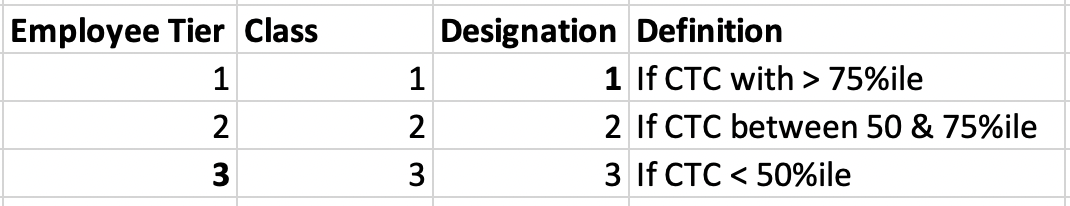
### Some Questions this data can Answer: <br>
    1. Show creme de la creme records from the data (Filter 1 from all the flags)
    2. What's the current positioning of the employee
    3. Where to next? Pitch (After seeing their present cluster)
    

## Macro Analysis Ex: 
Since we are doing clustering at employee level we have to bring characterics of employees only. 
1. Top 10 employees (earning more than most of the employees in the company) (tier 1) <br>
    
    1a. Top 10 employees of data science in Amazon / TCS etc earning more than their peers (class 1) <br>
    1b. Bottom 10 employees of data science in Amazon / TCS etc earning less than their peers (class 3) <br>
2. Bottom 10 employees (earning less than most of the employees in the company) (tier 3)
3. Top 10 employees in the amazon- data science- having 5/6/7 years of experience earning more than their peers

## Micro Analysis Examples: 
1. Top 10 companies (basis on their offered CTC) - grouped_c, sort by descending, head(10)
2. Top 2 positions in every company (basis on their offered CTC) - grouped_c_j, sort by descending, head(10)

In [125]:
x=final.copy()

In [126]:
final.shape

(140841, 11)

In [127]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140841 entries, 0 to 140840
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   company                140841 non-null  object 
 1   orgyear                140841 non-null  float64
 2   ctc                    140841 non-null  int64  
 3   ctc_updated_year       140841 non-null  float64
 4   years_of_experience    140841 non-null  float64
 5   job_position           140841 non-null  object 
 6   classs                 140841 non-null  int64  
 7   designation            140841 non-null  int64  
 8   tier                   140841 non-null  int64  
 9   company_cluster_n      140841 non-null  float64
 10  company_job_cluster_n  140841 non-null  float64
dtypes: float64(5), int64(4), object(2)
memory usage: 12.9+ MB


In [128]:
#x.to_csv('cln.csv')

# Unsupervised Learning

## KMeans


1. Check Clustering Tendency
2. Do elbow method etc for checking the number of optimal clusters (bring it to 3)
3. Do kmeans clustering
4. Hierarchial clustering of sample dataset (shuffle and take 50k rows)

## Label encoding

In [129]:
x.shape

(140841, 11)

In [130]:
x['company'].unique()

array(['deloitte india', 'reliance infocomm limited', 'Others', ...,
       'gloify', 'mu sigma', 'sumtotal systems'], dtype=object)

In [131]:
from sklearn import preprocessing
 
label_encoder = preprocessing.LabelEncoder()
x['company']= label_encoder.fit_transform(x['company'])
 
x['company'].unique()

array([ 693, 2158,   19, ..., 1014, 1717, 2444])

In [132]:
x['job_position']= label_encoder.fit_transform(x['job_position'])
x['job_position'].unique()

array([279, 184,  88, 212, 127, 182, 160, 132, 159,  16, 322, 339, 434,
       516, 359, 148, 303, 311, 112, 300, 519,  87, 136, 335,  27, 561,
        51,   3, 467, 557, 375, 435, 318, 254, 451, 436, 150,  20,  94,
       370, 186, 245, 458, 204, 512, 275, 379, 208, 374, 270,  66, 542,
       167,  42, 459, 169,  47, 299, 470,  45, 443, 207, 369, 301, 157,
       231, 489, 163,  60, 185, 452, 400,  95, 460, 377, 206,  92,  48,
       221, 558, 348, 237, 577, 317, 243, 461,  11, 393,  77, 352, 258,
       397, 313, 534, 257, 472, 525,  68, 569, 541, 382, 170,  89, 344,
       411, 302, 103, 373, 351, 367, 291, 327, 465,  81, 320, 362, 139,
       415,  67, 115, 517, 538,  65, 197, 329, 239, 430, 566, 261, 410,
       280, 282, 172, 268, 346, 336, 247, 439, 164, 380, 448, 230, 252,
       567, 274, 110, 504, 101, 128, 381, 441,  62, 466, 314, 412, 528,
       193,  46, 571, 406,  55, 326, 116, 450, 236, 315, 264, 102, 114,
        41,  23, 232, 527, 524, 174, 123, 384, 480,   4,  61, 15

x=pd.read_csv('suraajcln.csv',index_col=0)

In [133]:
x.head()

,company,orgyear,ctc,ctc_updated_year,years_of_experience,job_position,classs,designation,tier,company_cluster_n,company_job_cluster_n
0,693,2016.0,1100000,2020.0,6.0,279,1,2,2,2.0,3.0
1,2158,2018.0,449999,2019.0,4.0,184,3,3,3,3.0,3.0
2,19,2015.0,2000000,2020.0,7.0,88,1,1,1,3.0,3.0
3,2619,2017.0,700000,2019.0,5.0,88,3,3,3,2.0,2.0
4,2177,2017.0,1400000,2019.0,5.0,184,1,2,1,3.0,3.0


In [134]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140841 entries, 0 to 140840
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   company                140841 non-null  int64  
 1   orgyear                140841 non-null  float64
 2   ctc                    140841 non-null  int64  
 3   ctc_updated_year       140841 non-null  float64
 4   years_of_experience    140841 non-null  float64
 5   job_position           140841 non-null  int64  
 6   classs                 140841 non-null  int64  
 7   designation            140841 non-null  int64  
 8   tier                   140841 non-null  int64  
 9   company_cluster_n      140841 non-null  float64
 10  company_job_cluster_n  140841 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 12.9 MB


In [135]:
x.drop(columns=['orgyear'],inplace=True)
x.drop(columns=['ctc_updated_year'],inplace=True)
#x.drop(columns=['job_position'],inplace=True)


In [136]:
x.head()

,company,ctc,years_of_experience,job_position,classs,designation,tier,company_cluster_n,company_job_cluster_n
0,693,1100000,6.0,279,1,2,2,2.0,3.0
1,2158,449999,4.0,184,3,3,3,3.0,3.0
2,19,2000000,7.0,88,1,1,1,3.0,3.0
3,2619,700000,5.0,88,3,3,3,2.0,2.0
4,2177,1400000,5.0,184,1,2,1,3.0,3.0


In [137]:
x.isnull().sum()

company                  0
ctc                      0
years_of_experience      0
job_position             0
classs                   0
designation              0
tier                     0
company_cluster_n        0
company_job_cluster_n    0
dtype: int64

In [138]:
from sklearn.preprocessing import MinMaxScaler
ms = MinMaxScaler()
# ------- fix X #do this after label encoding
x[['ctc']] = ms.fit_transform(x[['ctc']])
print(x.head())

   company       ctc  years_of_experience  job_position  classs  designation  \
0      693  0.330330                  6.0           279       1            2   
1     2158  0.135134                  4.0           184       3            3   
2       19  0.600600                  7.0            88       1            1   
3     2619  0.210210                  5.0            88       3            3   
4     2177  0.420420                  5.0           184       1            2   

   tier  company_cluster_n  company_job_cluster_n  
0     2                2.0                    3.0  
1     3                3.0                    3.0  
2     1                3.0                    3.0  
3     3                2.0                    2.0  
4     1                3.0                    3.0  


Clustering Tendancy

In [139]:
!pip install pyclustertend

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans
from pyclustertend import hopkins
from sklearn.preprocessing import scale

In [141]:
x.dropna(inplace=True)

In [143]:
x

,company,ctc,years_of_experience,job_position,classs,designation,tier,company_cluster_n,company_job_cluster_n
0,693,0.330330,6.0,279,1,2,2,2.0,3.0
1,2158,0.135134,4.0,184,3,3,3,3.0,3.0
2,19,0.600600,7.0,88,1,1,1,3.0,3.0
3,2619,0.210210,5.0,88,3,3,3,2.0,2.0
4,2177,0.420420,5.0,184,1,2,1,3.0,3.0
...,...,...,...,...,...,...,...,...,...
140836,300,0.675675,11.0,279,1,1,1,3.0,3.0
140837,186,0.066066,14.0,279,3,2,3,1.0,1.0
140838,2702,0.150150,5.0,279,3,3,3,2.0,3.0
140839,41,0.210210,1.0,279,3,2,3,2.0,2.0


In [144]:
hop=hopkins(x,150)

In [145]:
print(hop)

0.06334270569598614


A value close to 1 tends to indicate the data is highly clustered, random data will tend to result in values around 0.5, and uniformly distributed data will tend to result in values close to 0.

In [146]:
#o=x.copy(deep=True)

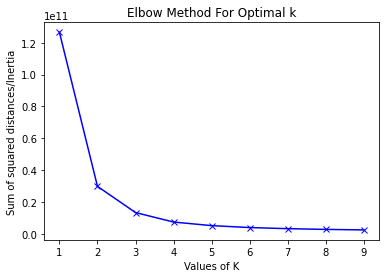

In [147]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(x)
  Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [148]:
kmeans = KMeans(n_clusters=3)

kmeans.fit(x)
print(kmeans.cluster_centers_)
print(kmeans.cluster_centers_.shape)

[[2.34049358e+03 3.52817532e-01 6.38508394e+00 2.04635652e+02
  2.18770295e+00 2.10785916e+00 2.23821551e+00 2.47713140e+00
  2.52524567e+00]
 [2.08229821e+02 3.22948042e-01 6.90748563e+00 2.02310100e+02
  2.21277163e+00 2.16670472e+00 2.24099022e+00 2.73364539e+00
  2.72192412e+00]
 [1.29177321e+03 3.56499683e-01 6.43112703e+00 2.04035511e+02
  2.18486762e+00 2.09934418e+00 2.23665290e+00 2.50097158e+00
  2.56312849e+00]]
(3, 9)


In [149]:
x['k-m label']=kmeans.fit_predict(x)

In [150]:
x

,company,ctc,years_of_experience,job_position,classs,designation,tier,company_cluster_n,company_job_cluster_n,k-m label
0,693,0.330330,6.0,279,1,2,2,2.0,3.0,1
1,2158,0.135134,4.0,184,3,3,3,3.0,3.0,0
2,19,0.600600,7.0,88,1,1,1,3.0,3.0,1
3,2619,0.210210,5.0,88,3,3,3,2.0,2.0,0
4,2177,0.420420,5.0,184,1,2,1,3.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...
140836,300,0.675675,11.0,279,1,1,1,3.0,3.0,1
140837,186,0.066066,14.0,279,3,2,3,1.0,1.0,1
140838,2702,0.150150,5.0,279,3,3,3,2.0,3.0,0
140839,41,0.210210,1.0,279,3,2,3,2.0,2.0,1


In [151]:
z=final.copy()
z.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140841 entries, 0 to 140840
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   company                140841 non-null  object 
 1   orgyear                140841 non-null  float64
 2   ctc                    140841 non-null  int64  
 3   ctc_updated_year       140841 non-null  float64
 4   years_of_experience    140841 non-null  float64
 5   job_position           140841 non-null  object 
 6   classs                 140841 non-null  int64  
 7   designation            140841 non-null  int64  
 8   tier                   140841 non-null  int64  
 9   company_cluster_n      140841 non-null  float64
 10  company_job_cluster_n  140841 non-null  float64
dtypes: float64(5), int64(4), object(2)
memory usage: 12.9+ MB


In [152]:
#x.drop(columns=['company'],inplace=True)
#x.drop(columns=['ctc'],inplace=True)
#x.drop(columns=['orgyear'],inplace=True)
#x.drop(columns=['job_position'],inplace=True)
#x.drop(columns=['ctc_updated_year'],inplace=True)
#x.info()

In [153]:
x.info()
z.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140841 entries, 0 to 140840
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   company                140841 non-null  int64  
 1   ctc                    140841 non-null  float64
 2   years_of_experience    140841 non-null  float64
 3   job_position           140841 non-null  int64  
 4   classs                 140841 non-null  int64  
 5   designation            140841 non-null  int64  
 6   tier                   140841 non-null  int64  
 7   company_cluster_n      140841 non-null  float64
 8   company_job_cluster_n  140841 non-null  float64
 9   k-m label              140841 non-null  int32  
dtypes: float64(4), int32(1), int64(5)
memory usage: 11.3 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 140841 entries, 0 to 140840
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 

In [154]:
#q=pd.merge(x, z, how ='inner', on =['years_of_experience', 'tier','classs','designation'])
#q.info()

In [155]:
q=pd.concat([z,x['k-m label']], axis=1)
q.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140841 entries, 0 to 140840
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   company                140841 non-null  object 
 1   orgyear                140841 non-null  float64
 2   ctc                    140841 non-null  int64  
 3   ctc_updated_year       140841 non-null  float64
 4   years_of_experience    140841 non-null  float64
 5   job_position           140841 non-null  object 
 6   classs                 140841 non-null  int64  
 7   designation            140841 non-null  int64  
 8   tier                   140841 non-null  int64  
 9   company_cluster_n      140841 non-null  float64
 10  company_job_cluster_n  140841 non-null  float64
 11  k-m label              140841 non-null  int32  
dtypes: float64(5), int32(1), int64(4), object(2)
memory usage: 13.4+ MB


In [158]:
q


,company,orgyear,ctc,ctc_updated_year,years_of_experience,job_position,classs,designation,tier,company_cluster_n,company_job_cluster_n,k-m label
0,deloitte india,2016.0,1100000,2020.0,6.0,others,1,2,2,2.0,3.0,1
1,reliance infocomm limited,2018.0,449999,2019.0,4.0,fullstack devloper,3,3,3,3.0,3.0,0
2,Others,2015.0,2000000,2020.0,7.0,backend engineer,1,1,1,3.0,3.0,1
3,tokopedia,2017.0,700000,2019.0,5.0,backend engineer,3,3,3,2.0,2.0,0
4,rift group,2017.0,1400000,2019.0,5.0,fullstack devloper,1,2,1,3.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
140836,barclays,2011.0,2250000,2019.0,11.0,others,1,1,1,3.0,3.0,1
140837,apple inc,2008.0,220000,2019.0,14.0,others,3,2,3,1.0,1.0,1
140838,upgradcom,2017.0,500000,2020.0,5.0,others,3,3,3,2.0,3.0,0
140839,accolite,2021.0,700000,2021.0,1.0,others,3,2,3,2.0,2.0,1


In [1]:
z=x.sample(frac=0.25)
#the most we could do without crashing

NameError: name 'x' is not defined

In [168]:
z=z.drop(columns='k-m label')

In [169]:
z.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35210 entries, 7946 to 60911
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   company                35210 non-null  int64  
 1   ctc                    35210 non-null  float64
 2   years_of_experience    35210 non-null  float64
 3   job_position           35210 non-null  int64  
 4   classs                 35210 non-null  int64  
 5   designation            35210 non-null  int64  
 6   tier                   35210 non-null  int64  
 7   company_cluster_n      35210 non-null  float64
 8   company_job_cluster_n  35210 non-null  float64
dtypes: float64(4), int64(5)
memory usage: 2.7 MB


In [170]:
import sys

In [171]:
sys.setrecursionlimit(100000)

In [ ]:
import scipy.cluster.hierarchy as sch
dendrogrm = sch.dendrogram(sch.linkage(z, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('placements')
plt.ylabel('Euclidean distance')
plt.show()

In [ ]:
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
model.fit(z)

In [ ]:
z['Aglo-label'] = model.fit_predict(z)

In [ ]:
z.head()